<a href="https://colab.research.google.com/github/Maximilianwte/GenAI-Course/blob/main/BDD_GenAI_Multimodal_Data_with_Gemma_and_OpenAI_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!huggingface-cli login --token INPUT_HF_TOKEN_HERE!


!git clone https://github.com/Maximilianwte/GenAI-Course.git
from PIL import Image
import pandas as pd
import requests
import glob
import torch
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration

model_id = "google/paligemma-3b-mix-224"
device = "cuda:0"
#dtype = torch.bfloat16

model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    device_map=device,
    revision="bfloat16",
).eval()
processor = AutoProcessor.from_pretrained(model_id)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
fatal: destination path 'GenAI-Course' already exists and is not an empty directory.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/paligemma/configuration_paligemma.py:137: FutureWarning: The `vocab_size` attribute is deprecated and will be removed in v4.44, Please use `text_config.vocab_size` instead.
  warnings.warn(
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See h

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
image_paths = glob.glob('/content/GenAI-Course/Datasets/creative-ads/*.jpg')
print(f'{len(image_paths)} images found')

15 images found


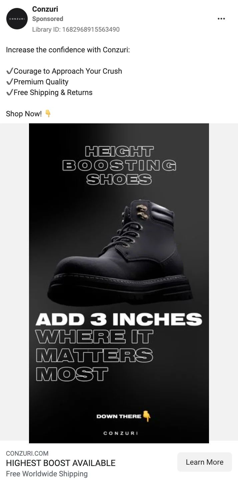

In [ ]:
image = Image.open(image_paths[1])
image = image.resize((int(image.width / 3), int(image.height / 3)))
image

## Google Gemma (Local)

In [ ]:
def predict_gemma(image, prompt):
  model_inputs = processor(text=prompt, images=image, return_tensors="pt").to(model.device)
  input_len = model_inputs["input_ids"].shape[-1]

  with torch.inference_mode():
      generation = model.generate(**model_inputs, max_new_tokens=200, temperature=0.3)
      generation = generation[0][input_len:]
      decoded = processor.decode(generation, skip_special_tokens=True)
      return decoded

In [ ]:
response = predict_gemma(image, "What are the colors that are mostly used in the image? What emotional response could humans feel from them?")
print(response)

/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.3` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


The image primarily uses black and yellow colors, which are known to evoke feelings of confidence and happiness.


## OpenAI GPT Vision (API)

In [ ]:
!pip install openai -qq
import base64
from openai import OpenAI
pd.set_option('display.max_colwidth', None)
import os
os.environ["OPENAI_API_KEY"] = "INPUT_OPENAI_TOKEN_HERE"
client = OpenAI()

def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')


In [ ]:
def predict_gpt(image_path, prompt):
  base64_image = encode_image(image_path)

  response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
      {
        "role": "user",
        "content": [
          {
            "type": "text",
            "text": prompt,
          },
          {
            "type": "image_url",
            "image_url": {
              "url":  f"data:image/jpeg;base64,{base64_image}"
            },
          },
        ],
      }
    ],
  )

  return response.choices[0].message.content

In [ ]:
response = predict_gpt(image_paths[1], 'What is displayed on the image?')
print(response)

The image displays an advertisement for Conzuri, featuring height-boosting shoes. The text promotes the shoes by highlighting advantages such as increased confidence, the ability to approach a crush, premium quality, and free shipping and returns. It features an image of a black boot and includes phrases like "Add 3 inches where it matters most" and "Highest Boost Available." The overall theme emphasizes confidence and attractiveness.


## Building a loop to describe all images

In [ ]:
df = pd.DataFrame()

In [ ]:
prompt = "What is shown on the image?"

In [ ]:
counter = df.shape[0]
for image_path in image_paths:
  df.at[counter, 'image_path'] = image_path
  df.at[counter, 'description'] = predict_gpt(image_path, prompt)
  break

In [ ]:
df

,image_path,description
0,/content/GenAI-Course/Datasets/top-ads/13.jpg,"The image shows a Nike advertisement featuring the ""Pegasus Trail GTX"" shoes. The shoes are designed for versatility, allowing movement from road to trail. They are displayed in a wet environment, with water splashing around them, emphasizing their suitability for outdoor activities. The text highlights their responsive GORE-TEX material and promotes confidence in using them. The image encourages viewers to shop for these shoes on the Nike website."
